# BLG607 - PROJECT DEMO

Available at https://github.com/tolgahanturker/stockPricePredicion.

# Initials

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf
import datetime as dt
import math
import numpy as np
import pandas as pd
import seaborn as sb
sb.set_style('white', {'axes.spines.right': False, 'axes.spines.top': False})

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping

from bs4 import BeautifulSoup

In [ ]:
# tickers for companies
stockCodes = ['SASA.IS']

# start and end dates for financial data (last ~5 years)
startDate = dt.datetime(2017, 11, 20)
endDate = dt.datetime(2022, 11, 24)

# split ratio for training and testing datasets
splitRatio = 0.8

# number of past days the model will take into account while training
n_pasts = [60]

# number of experiments
n_run = 1

# number of epochs with no improvement after which training will be stopped (for early stopping)
n_patience = 8

# batch size for training
batchSize = 16

# number of epoch for training
n_epoch = 50

# list of results
res = []

# Data Preprocessing

## Data Collection

In [ ]:
# getting financial data between start and end dates from Yahoo Finance using yfinance API
data = yf.download(stockCodes[0], start = startDate, end = endDate)

print(data.shape)
data.head(10)

[*********************100%***********************]  1 of 1 completed
(1277, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-20,1.080971,1.082812,1.012834,1.029408,0.990806,16524139
2017-11-21,1.007310,1.101227,0.981529,1.084654,1.043981,28141419
2017-11-22,1.178571,1.300111,1.178571,1.300111,1.251359,230051352
2017-11-23,1.351674,1.436384,1.307477,1.307477,1.258448,335336850
2017-11-24,1.289062,1.290904,1.211718,1.252232,1.205275,131029590
2017-11-27,1.283538,1.294587,1.237500,1.241183,1.194640,56605387
2017-11-28,1.233817,1.244866,1.178571,1.178571,1.134376,76865878
2017-11-29,1.180413,1.254073,1.149107,1.252232,1.205275,94757465
2017-11-30,1.259598,1.425334,1.235658,1.313002,1.263766,266507140


In [ ]:
# 2020-07-24 removing 2 decimal digits in BIST100
if stockCodes[0] == 'XU100.IS':
    data2 = data.loc[:'2020-07-24']
    data3 = data2[['Open', 'High', 'Low', 'Close', 'Adj Close']] / 100
    data3['Volume'] = data2['Volume']
    data4 = data3.append(data.loc['2020-07-25':])
    del data
    data = data4.copy()
else:
    print('Stock code is not XU100.IS.')

Stock code is not XU100.IS.


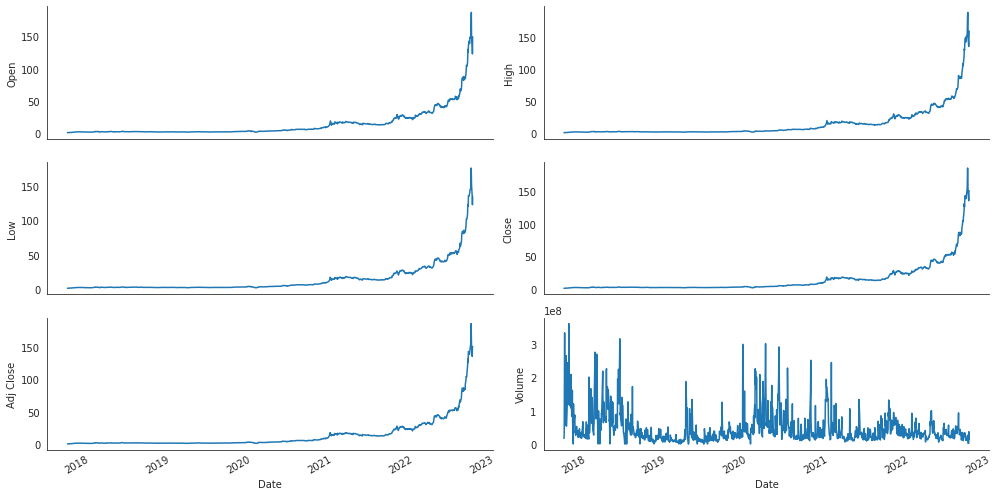

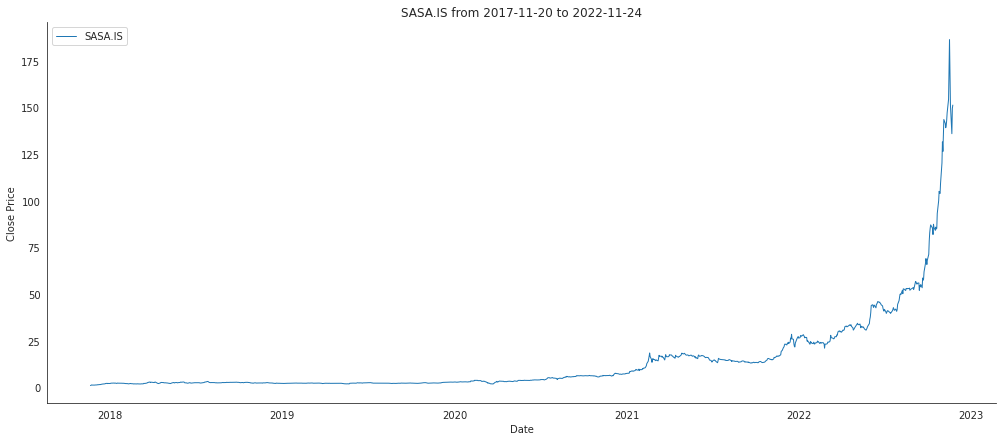

In [ ]:
# plotting line charts for all features
df_plot = data.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows = nrows, ncols = ncols, sharex = True, figsize = (14, 7))
for id, ax in enumerate(fig.axes):
    sb.lineplot(data = df_plot.iloc[:, id], ax = ax)
    ax.tick_params(axis = 'x', rotation = 30, labelsize = 10, length = 0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# plotting line chart for 'Close'
years = mdates.YearLocator() 
fig, ax1 = plt.subplots(figsize = (17, 7))
ax1.xaxis.set_major_locator(years)
ax1.legend([stockCodes[0]], fontsize = 12)
plt.title(stockCodes[0] + ' from ' + str(startDate.date()) + ' to ' + str(endDate.date()))
sb.lineplot(data = data['Close'], label = stockCodes[0], linewidth = 1.0)
plt.ylabel('Close Price')
plt.show()

## Data Cleaning & Feature Selection

In [ ]:
# processing bull/bear questionnaire data
with open('/content/drive/MyDrive/StockPricePrediction/data_sentiment_{}.html'.format(stockCodes[0]), 'r') as f:
    contents = f.read()
    soup = BeautifulSoup(contents, 'lxml')

    table = soup.find('table', attrs={'id':'sentiments_table'})
    table_body = table.find('tbody')
    rows = table_body.find_all('tr')

In [ ]:
trendQuestionnaire = []

for row in rows:
    cols = row.find_all('td')
    trendQuestionnaire.append(
        {
            'Start Date': pd.to_datetime(cols[0].text.strip()),
            #'Name': cols[1].text.strip(),
            'Trend': -1 if 'newSmallBearIcon2' in cols[2].find('span')['class'] else 1,
            #'Open': cols[3].text.strip(),
            #'End Date': pd.to_datetime(cols[4].text.strip()),
            #'Change':  cols[5].text.strip()
        }
    )

# getting bull/bear questionnaire data
dataQuestionnaire = pd.DataFrame(trendQuestionnaire)

# let's check it
print('Bull/Bear Questionnaire Data is processing...')
dataQuestionnaire.head()

Bull/Bear Questionnaire Data is processing...


,Start Date,Trend
0,2022-11-23,-1
1,2022-11-23,1
2,2022-11-23,-1
3,2022-11-23,1
4,2022-11-23,1


In [ ]:
trend = []
for dat in range(len(data)):
    # getting trend data for corresponding date from data
    ds = dataQuestionnaire[dataQuestionnaire['Start Date'] == data.index[dat]]
    
    # legnth of ds
    length_ds = len(ds)

    # if there is no corresponding trend data, then i'll assume it as neutral (means zero)
    if length_ds == 0:
        trend.append(0)
    # if there is some trend data, then i'm making majority voting
    elif len(ds[ds['Trend'] == 1]) / length_ds >= 0.5:
        trend.append(1)
    else:
        trend.append(-1)

In [ ]:
# a new feature is added
data['Sentiment'] = trend

# columns: High, Low, Open, Close, Volume, Adj Close, Sentiment
print(data.shape)

data.head()

(1277, 7)


,Open,High,Low,Close,Adj Close,Volume,Sentiment
Date,,,,,,,
2017-11-20,1.080971,1.082812,1.012834,1.029408,0.990806,16524139,-1
2017-11-21,1.007310,1.101227,0.981529,1.084654,1.043981,28141419,1
2017-11-22,1.178571,1.300111,1.178571,1.300111,1.251359,230051352,1
2017-11-23,1.351674,1.436384,1.307477,1.307477,1.258448,335336850,1
2017-11-24,1.289062,1.290904,1.211718,1.252232,1.205275,131029590,-1


In [ ]:
# feature selection
data_featured = data[['Close', 'Sentiment']].copy()

print(data_featured.shape)
data_featured.head()

(1277, 2)


,Close,Sentiment
Date,,
2017-11-20,1.029408,-1
2017-11-21,1.084654,1
2017-11-22,1.300111,1
2017-11-23,1.307477,1
2017-11-24,1.252232,-1


## Data Splitting (Train & Test) & Scaling

In [ ]:
# determining the number of samples in training dataset
n_trainSamples = math.floor(data_featured.shape[0] * splitRatio)

# let's check the number of training samples
print('\nNumber of samples in training dataset is determined as to be {}.'.format(n_trainSamples))

# creating training dataset
dataTraining = data_featured[data_featured.index < data_featured.index[n_trainSamples]].copy()
print('Shape of dataTraining: {}.'.format(dataTraining.shape))

# creating testing dataset
dataTesting = data_featured[data_featured.index >= data_featured.index[n_trainSamples]].copy()
print('Shape of dataTesting: {}.'.format(dataTesting.shape))


Number of samples in training dataset is determined as to be 1021.
Shape of dataTraining: (1021, 2).
Shape of dataTesting: (256, 2).


In [ ]:
# scaler definition for scaling 'Close' feature to a range between 0 and 1
minmax_scaler = MinMaxScaler(feature_range = (0, 1))

# applying min-max scaling
dataTrainingScaled = minmax_scaler.fit_transform(np.array(dataTraining))

# creating a separate scaler that works on a single column for scaling predictions
minmax_scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(dataTraining['Close'])
np_Close_scaled = minmax_scaler_pred.fit_transform(df_Close)

# let's check it
print('Shape of dataTrainingScaled: {}'.format(dataTrainingScaled.shape))
print('First a few training samples:')
print(dataTrainingScaled[:5])

Shape of dataTrainingScaled: (1021, 2)
First a few training samples:
[[0.         0.        ]
 [0.00317082 1.        ]
 [0.01553686 1.        ]
 [0.01595963 1.        ]
 [0.01278887 0.        ]]


## Data Transformation (Input & Output Formatting using Sliding Window)

In [ ]:
# input and output lists for training dataset
trainX = []
trainY = []

# creating input and output lists for training dataset using sliding window technique
for l in range(n_pasts[0], dataTrainingScaled.shape[0]):
    trainX.append(dataTrainingScaled[l - n_pasts[0]: l])
    trainY.append(dataTrainingScaled[l, 0])

# let's check the first three input samples
print('First three samples for input part:')
print(trainX[:3])
# let's check the first three output samples
print('First three samples for output part:')
print(trainY[:3])

# converting input and output lists to numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# let's check the shape of input and output arrays
print('Input Shape (Training): {}'.format(trainX.shape))
print('Output Shape (Training): {}'.format(trainY.shape))

First three samples for input part:
[array([[0.        , 0.        ],
       [0.00317082, 1.        ],
       [0.01553686, 1.        ],
       [0.01595963, 1.        ],
       [0.01278887, 0.        ],
       [0.01215472, 0.        ],
       [0.00856113, 1.        ],
       [0.01278887, 1.        ],
       [0.01627673, 1.        ],
       [0.01564258, 1.        ],
       [0.01860196, 1.        ],
       [0.02430938, 1.        ],
       [0.02177277, 1.        ],
       [0.02399233, 1.        ],
       [0.02705742, 1.        ],
       [0.02885416, 1.        ],
       [0.03413881, 1.        ],
       [0.03635837, 1.        ],
       [0.04016334, 1.        ],
       [0.04322843, 1.        ],
       [0.0467163 , 1.        ],
       [0.04777321, 1.        ],
       [0.05221234, 0.        ],
       [0.05200095, 1.        ],
       [0.06119624, 1.        ],
       [0.06626951, 1.        ],
       [0.05834253, 1.        ],
       [0.06637516, 1.        ],
       [0.06225316, 1.        ],
      

# Training

## Building Stacked LSTM Model

In [ ]:
# determining number of units for LSTM model
n_neurons = trainX.shape[1] * trainX.shape[2]

print('Number of neurons: {}'.format(n_neurons))

# creating a stacked LSTM model (relu or not ???, dropouts or not ???)
model = Sequential()

model.add(LSTM(units = n_neurons, return_sequences = True, input_shape = (trainX.shape[1], trainX.shape[2])))
#model.add(Dropout(0.1))
model.add(LSTM(units = n_neurons, return_sequences = True))
#model.add(Dropout(0.1))
model.add(LSTM(units = n_neurons, return_sequences = False))
model.add(Dense(30, activation = 'relu'))
model.add(Dense(1))

model.summary()

# compiling the model (farklı learning rate'ler denenmedi ???)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# early stopping condition for training
early_stop = EarlyStopping(monitor = 'loss', patience = n_patience, verbose = 1)

Number of neurons: 120
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 60, 120)           59040     
                                                                 
 lstm_7 (LSTM)               (None, 60, 120)           115680    
                                                                 
 lstm_8 (LSTM)               (None, 120)               115680    
                                                                 
 dense_4 (Dense)             (None, 30)                3630      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 294,061
Trainable params: 294,061
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
61/61 [==============================] - 5s 14ms/step - loss: 0.0122
Epoch 2/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0017
Epoch 3/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0014
Epoch 4/50
61/61 [==============================] - 1s 12ms/step - loss: 0.0018
Epoch 5/50
61/61 [==============================] - 1s 12ms/step - loss: 0.0013
Epoch 6/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0020
Epoch 7/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0012
Epoch 8/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0010
Epoch 9/50
61/61 [==============================] - 1s 14ms/step - loss: 0.0016
Epoch 10/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 11/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 12/50
61/61 [==============================] - 1s 13ms/step - loss: 0.0013
Epoch 13/50
61/61 [==================

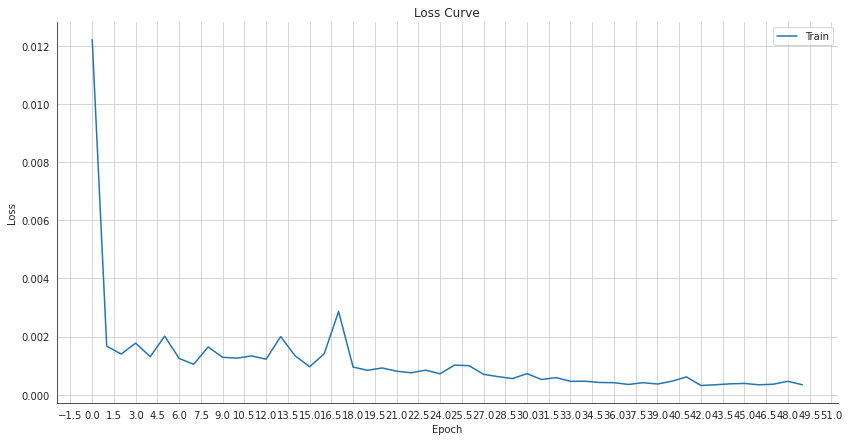

In [ ]:
# training
history = model.fit(trainX, trainY, batch_size = batchSize, epochs = n_epoch, callbacks = [early_stop], verbose = 1)

# plotting loss curve
fig, ax = plt.subplots(figsize = (14, 7), sharex = True)
sb.lineplot(data = history.history['loss'])
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
ax.xaxis.set_major_locator(plt.MaxNLocator(n_epoch))
plt.legend(['Train', 'Test'], loc = 'upper right')
plt.grid()
plt.show()

# Testing

In [ ]:
# getting last 60 training samples
pastTrainingData = dataTraining.tail(n_pasts[p])

# appending pastTrainingData to dataTesting 
dataTest = pastTrainingData.append(dataTesting, ignore_index = True)

# applying min-max scaling
dataTestingScaled = minmax_scaler.fit_transform(np.array(dataTest))

# let's check it
print('Shape of dataTestingScaled: {}'.format(dataTestingScaled.shape))
print('First a few testing samples:')
print(dataTestingScaled[:5])

Shape of dataTestingScaled: (316, 2)
First a few testing samples:
[[0.00363552 0.        ]
 [0.00248139 1.        ]
 [0.00328928 1.        ]
 [0.00421259 1.        ]
 [0.00582838 1.        ]]


## Data Transformation (Input & Output Formatting using Sliding Window)

In [ ]:
# input and output lists for testing dataset
testX = []
testY = []

# creating input and output lists for training dataset using sliding window technique
for h in range(n_pasts[p], dataTestingScaled.shape[0]):
    testX.append(dataTestingScaled[h - n_pasts[p]:h])
    testY.append(dataTestingScaled[h, 0])

# converting input and output lists to numpy array
testX, testY = np.array(testX), np.array(testY)

# let's check the first three input samples
print(testX[:3])
# let's check the first three output samples
print(testY[:3])

# let's check the shape of input and output arrays
print('Input Shape (Test): {}'.format(testX.shape))
print('Output Shape (Test): {}'.format(testY.shape))

[[[3.63552487e-03 0.00000000e+00]
  [2.48138580e-03 1.00000000e+00]
  [3.28928204e-03 1.00000000e+00]
  [4.21258890e-03 1.00000000e+00]
  [5.82838140e-03 1.00000000e+00]
  [6.29003483e-03 1.00000000e+00]
  [6.86709886e-03 1.00000000e+00]
  [6.23232677e-03 1.00000000e+00]
  [4.32800501e-03 1.00000000e+00]
  [3.28928204e-03 1.00000000e+00]
  [4.50112367e-03 0.00000000e+00]
  [3.52010876e-03 1.00000000e+00]
  [3.52010876e-03 1.00000000e+00]
  [3.34699010e-03 0.00000000e+00]
  [1.78890565e-03 1.00000000e+00]
  [3.34699010e-03 1.00000000e+00]
  [2.19285653e-03 1.00000000e+00]
  [8.07890746e-04 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00]
  [7.50188195e-04 1.00000000e+00]
  [1.61578700e-03 1.00000000e+00]
  [9.81014909e-04 1.00000000e+00]
  [3.00074728e-03 1.00000000e+00]
  [1.44266834e-03 1.00000000e+00]
  [1.55807894e-03 1.00000000e+00]
  [1.90432176e-03 1.00000000e+00]
  [2.13514848e-03 1.00000000e+00]
  [2.13514848e-03 1.00000000e+00]
  [1.32725223e-03 1.00000000e+00]
  [1.38496028e

## Predictions

In [ ]:
# getting predicted values
y_pred_scaled = model.predict(testX)
y_pred = minmax_scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = minmax_scaler_pred.inverse_transform(testY.reshape(-1, 1))

8/8 [==============================] - 1s 7ms/step


## Evaluation

In [ ]:
# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Mean Absolute Error (MAE): {np.round(MAE, 2)}')

# Root Mean Squared Error (RMSE)
RMSE = mean_squared_error(y_test_unscaled, y_pred)
print(f'Root Mean Squared Error (RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

Mean Absolute Error (MAE): 0.26
Root Mean Squared Error (RMSE): 0.12
Mean Absolute Percentage Error (MAPE): 7.06 %


In [ ]:
# keeping track of results
resDict = {'stock': stockCodes[0], 'past': n_pasts[0], 'run': (0 + 1), 'mae': MAE, 'rmse': RMSE, 'mape': MAPE}
res.append(resDict)

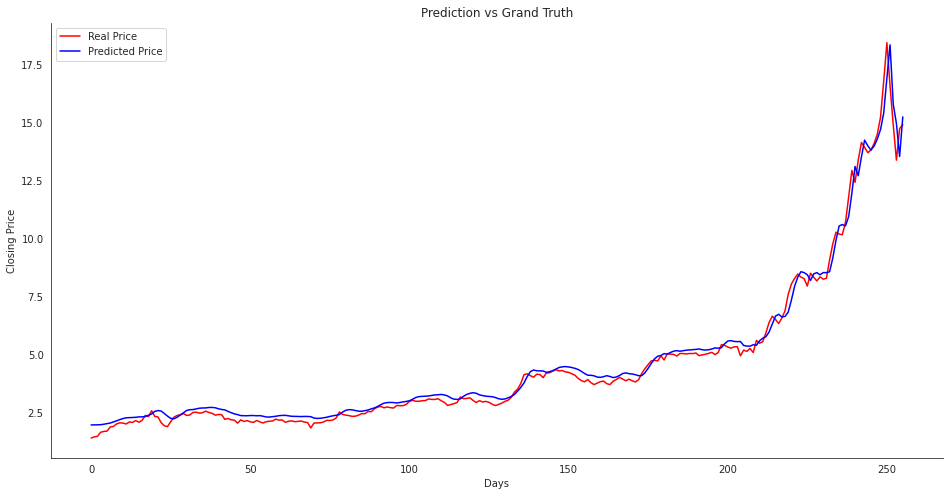

In [ ]:
# visualising results
plt.figure(figsize = (16, 8))
plt.plot(y_test_unscaled, color = 'red', label = 'Real Price')
plt.plot(y_pred, color = 'blue', label = 'Predicted Price')
plt.title('Prediction vs Grand Truth')
plt.xlabel('Days')
plt.ylabel('Closing Price')
plt.legend()
plt.show()

In [ ]:
res

[{'stock': 'SASA.IS',
  'past': 60,
  'run': 1,
  'mae': 0.2590846425221415,
  'rmse': 0.1207021621196077,
  'mape': 7.060160411043204}]

In [ ]:
df_res = pd.DataFrame(res)
df_res

,stock,past,run,mae,rmse,mape
0,SASA.IS,60,1,0.259085,0.120702,7.06016
